# CHEC cooling

Import numpy and pyplot. Make sure plots are displayed inline. Define some useful quantities.   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#
rhoWater = 1000.0        # density of water (kg/m^3)
specHeatWater = 4180.0   # specific heat capacity of water (J/kg C)
tempWater = 6.0          # temperature of input cooling water (C)
#
diamIn = 0.012           # diameter of pipe from chiller to FP (m)
lenIn = 12.0             # length of pipe from chiller to FP (m)
hgtDiffIn = 5.0          # height top minus height of bottom of inlet pipe (m)
#
pressDiffFP = 0.1*10**5  # pressure Diff. of input and output for focal plane (Pa)
tempDiffFP = 10          # temperature Diff. of cooling water for FP (C)
diamFP = 0.004           # diameter of cooling channel in FP (m)
lenFP = 0.35             # length of cooling channel in FP (m)
numFP = 5                # number of FP cooling channels
hgtDiffFP = 0.0          # height top minus height of bottom of FP (m)
deltaTFP = 2             # allowed temperature increase across FP (C)
powerFP = 32*2           # power lost in FP (W)
#
diamFPtoB = 0.012        # diameter of pipe from FP to body (m)
lenFPtoB = 0.2           # length of pipe from FP to body (m)
hgtDiffFPtoB = -0.1      # height top minus height of bottom FP to body (m)
#
# Pressure drop across car's radiator about 100 to 440 Pa, given by
# diamB = 0.03             # diameter of pipe in body (m)
# lenB = 0.3               # length of pipe in body (m)
#
# If assume serial rather than parallel system
diamB = 0.01             # approx. diameter of pipe in body (m)
lenB = 1.0               # approx. length of pipe in body (m)
hgtDiffB = -0.4          # height top minus height of bottom of body (m)
deltaTB = 10             # allowed temperature increase (C)
powerB = 600             # power lost in body (W)
#
diamOut = 0.012          # diameter of pipe from chiller to FP (m)
lenOut = 12              # length of pipe from camera to chiller (m)
                         # height top minus height of bottom of outlet pipe (m)
hgtDiffOut = -(hgtDiffIn - hgtDiffFP - hgtDiffFPtoB - hgtDiffB) 
#

See e.g. http://www.freestudy.co.uk/fluid%20mechanics/t1203.pdf, https://neutrium.net/fluid_flow/pressure-loss-in-pipe/ and http://www.kolumbus.fi/jukka.kiijarvi/clunowa/fluid_mechanics/pdf_articles/darcy_friction_factor.pdf for information on what follows. Note that there is considerable disagreement about various formulae and the constants that appear in them. This is because some people use metric and others imperial units and because there are bugs! There are also two definitions of the friction factor which differ by a factor of 4. More on the latter below.

First enter values of the dynamic viscosity of water, $\mu$, as a function of temperature and set up function to interpolate between these.

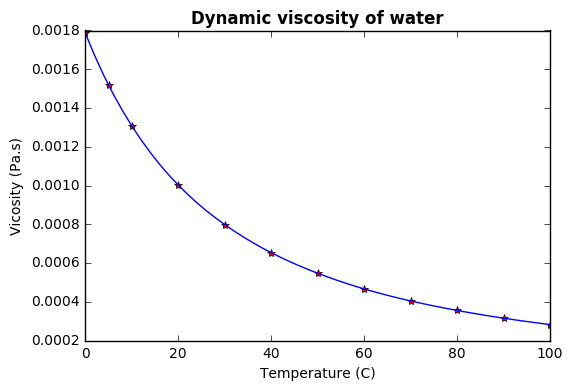

In [3]:
nTvals = 12
tempArr = np.array([0,5,10,20,30,40,50,60,70,80,90,100])
dynViscArr = np.array([1.787,1.519,1.308,1.002,0.798,\
                       0.653,0.547,0.466,0.404,0.355,0.315,0.282])*0.001
plt.plot(tempArr,dynViscArr,"r*")
from scipy.interpolate import interp1d
fDynVisc = interp1d(tempArr, dynViscArr, kind='cubic')
tempPlt = np.linspace(0,100,51)
plt.plot(tempPlt,fDynVisc(tempPlt))
ax = plt.gca()
ax.set_title("Dynamic viscosity of water", size = 12, weight = "bold")
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Vicosity (Pa.s)")

Now set up function to calculate Reynolds number, ${\rm Re} = \frac{\rho v D}{\mu}$. Here, $v$ is the velocity of the water, $\rho$ is its density, $D$ is the pipe diameter and $\mu$ is the dynamic viscosity. 

Reynold called.


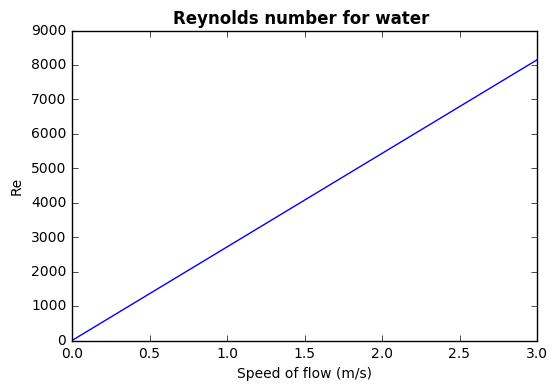

In [4]:
def Reynold(diam,temp,vel):
    '''
    Returns Reynolds number given diameter of pipe, temperature of water and water velocity
    '''
    if not hasattr(Reynold, "counter"):
        Reynold.counter = 0  # it doesn't exist yet, so initialize it
        print("Reynold called.")
    Reynold.counter += 1
    #
    Re = rhoWater*vel*diam/fDynVisc(temp)
    return Re
#
def velFromReynold(diam,reynold,temp):
    '''
    Returns velocity for a given Reynolds number, pipe diameter and water temperature
    '''
    if not hasattr(velFromReynold, "counter"):
        velFromReynold.counter = 0  # it doesn't exist yet, so initialize it
        print("velFromReynold called.")
    velFromReynold.counter += 1
    v = fDynVisc(temp)*reynold/(rhoWater*diam)
    return v
#
velPlot = np.linspace(0.0,3.0,51)
plt.plot(velPlot,Reynold(diamFP,tempWater,velPlot))
ax = plt.gca()
ax.set_title("Reynolds number for water ", size = 12, weight = "bold")
ax.set_xlabel("Speed of flow (m/s)")
ax.set_ylabel("Re")

Dynamic pressure difference $\Delta P$ is related to the length of the pipe $L$ and the above quantities by $\Delta P = f_D \frac{\rho L v^2}{2D}$. The volumetric flow rate $Q$ and the area of the pipe $A$ are related to the velocity by $v = \frac{Q}{A}$, and $A = \frac{\pi D^2}{4}$. Hence: $$\Delta P = \frac{8 f_D \rho L Q^2}{\pi^2 D^5}.$$ Substituting for the Darcy friction factor for laminar flow, $f_D = \frac{64}{{\rm Re}}$, and using ${\rm Re} = \frac{\rho v D}{\mu}$, we get the expression $\Delta P = \frac{128 \mu L Q}{\pi D^4}$. (Verified using information at https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation.)

Rearranging, $ D = \left( \frac{128 \mu L Q}{\pi \Delta P} \right)^\frac{1}{4}$. Express the flow in litres per minute.

diamPipeL called.
lPerMinToMperSec called.


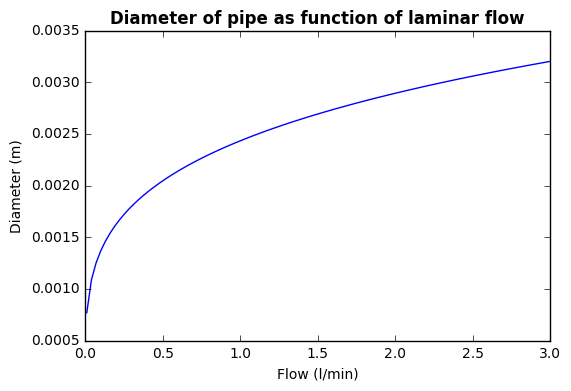

In [5]:
def lPerMinToMperSec(lPerMin):
    '''
    Convert litres per minute to m^3 per second
    '''
    if not hasattr(lPerMinToMperSec, "counter"):
        lPerMinToMperSec.counter = 0  # it doesn't exist yet, so initialize it
        print("lPerMinToMperSec called.")
    lPerMinToMperSec.counter += 1
    #
    flowConv = 1/60000
    return lPerMin*flowConv
#
def mPerSecToLperMin(mPerSec):
    '''
    Convert m^3 per second to litres per minute
    '''
    if not hasattr(mPerSecToLperMin, "counter"):
        mPerSecToLperMin.counter = 0  # it doesn't exist yet, so initialize it
        print("mPerSecToLperMin called.")
    mPerSecToLperMin.counter += 1
    #
    flowConv = 60000
    return mPerSec*flowConv
#
def diamPipeL(deltaP,flow,leng,temp):
    '''
    Return the diameter of a pipe that provides a certain laminar flow rate (in litre per min)
    for a given temperature and length  
    '''
    if not hasattr(diamPipeL, "counter"):
        diamPipeL.counter = 0  # it doesn't exist yet, so initialize it
        print("diamPipeL called.")
    diamPipeL.counter += 1
    #
    D = np.power(128*fDynVisc(temp)*leng*lPerMinToMperSec(flow)/(np.pi*deltaP),1/4)
    return D
#
flowPlot = np.linspace(0.01,3,101)
plt.plot(flowPlot,diamPipeL(pressDiffFP,flowPlot,lenFP,tempWater))
ax = plt.gca()
ax.set_title("Diameter of pipe as function of laminar flow", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Diameter (m)")

Plot relationship between volumetric flow rate and velocity, $v = \frac{4Q}{\pi D^2}$ and $Q = \frac{\pi D^2v}{4}$.

flowToVel called.
Flow of 1 l/min gives vel of 1.33 m/s
velToFlow called.
mPerSecToLperMin called.
Vel of 1 m/s gives flow of 0.75 l/min.


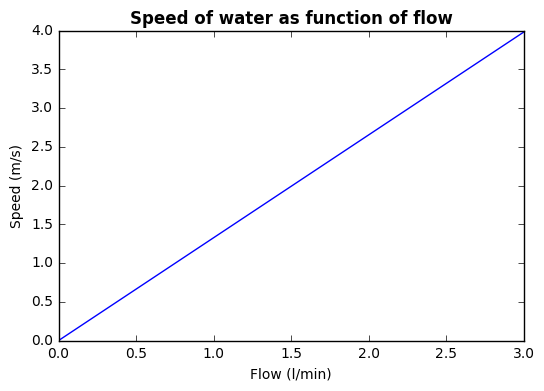

In [6]:
def flowToVel(diam,flow):
    '''
    Convert flow rate in litres per min to speed in m/s for a pipe of a given diameter
    '''
    if not hasattr(flowToVel, "counter"):
        flowToVel.counter = 0  # it doesn't exist yet, so initialize it
        print("flowToVel called.")
    flowToVel.counter += 1
    #
    v = 4*lPerMinToMperSec(flow)/(np.pi*diam**2)
    return v
#
def velToFlow(diam,vel):
    '''
    Convert speed in m/s to flow in litres per min for a pipe of a given diameter
    '''
    if not hasattr(velToFlow, "counter"):
        velToFlow.counter = 0  # it doesn't exist yet, so initialize it
        print("velToFlow called.")
    velToFlow.counter += 1
    #
    f = mPerSecToLperMin(vel*np.pi*diam**2/4)
    return f
#
print("Flow of 1 l/min gives vel of {:.2f} m/s".format(flowToVel(diamFP,1)))
print("Vel of 1 m/s gives flow of {:.2f} l/min.".format(velToFlow(diamFP,1)))
#
plt.plot(flowPlot,flowToVel(diamFP,flowPlot))
ax = plt.gca()
ax.set_title("Speed of water as function of flow", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Speed (m/s)")

Now plot Reynold's number for these flow rates. 

velFromReynold called.
Laminar flow up to 0.85 m/s or 0.64 l/min.
Turbulent flow from 1.47 m/s or 1.11 l/min.


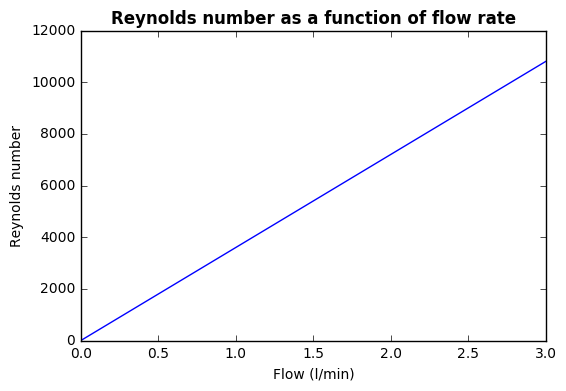

In [7]:
print("Laminar flow up to {:.2f} m/s or {:.2f} l/min.".\
      format((velFromReynold(diamFP,2300,tempWater)),\
             velToFlow(diamFP,velFromReynold(diamFP,2300,tempWater))))
print("Turbulent flow from {:.2f} m/s or {:.2f} l/min.". \
      format(velFromReynold(diamFP,4000,tempWater),\
             velToFlow(diamFP,velFromReynold(diamFP,4000,tempWater))))
plt.plot(flowPlot,Reynold(diamFP,tempWater,flowToVel(diamFP,flowPlot)))
ax = plt.gca()
ax.set_title("Reynolds number as a function of flow rate", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Reynolds number")

So flow rates up to about 0.6 litres per minute are in the laminar region for the CHEC focal plane.

Now repeat the calculation of the required pipe diameter for the case of turbulent flow. As above, pressure loss is given by $\Delta P = \frac{8 f_D L \rho Q^2}{\pi^2 D^5}$. There are varous apprximations for the friction factor in this region.
For smooth pipes, it is approximately ${f_D} = \frac{0.316}{\mathop{\rm Re^{0.25}}\nolimits}$ (Blasius equation). For pipes with roughness coefficient $e$, can use
$f_D = 0.25 \left[ \log \left( \frac{5.74}{{\rm Re}^{0.9}} + \frac{e}{3.7}  \right) \right]^{-2}$ (Swamee-Jain equation), or
$\frac{1}{\sqrt f_D} = -1.8 \log \left[ {\frac{{6.9}}{{{\mathop{\rm Re}\nolimits} }} + {{\left( {\frac{e}{{3.71}}} \right)}^{1.11}}} \right]$ (Haaland equation). 
The roughness coefficent is the ratio of the surface roughness, $k$, to the pipe diameter, $e = \frac {k}{D}$. (As mentoned above, there are two friction factors, the Darcy friction factor, $f_D$, and the Fanning friction factor, usually written $f$. Confusingly, $f_D = 4f$. Here, the Darcy friction factor is used.)

Have a look at some parameterisations of the Darcy friction factor.

Roughness coefficient is 0.04.
frictCoeffBlas called.
frictCoeffHaal called.
frictCoeffSJ called.


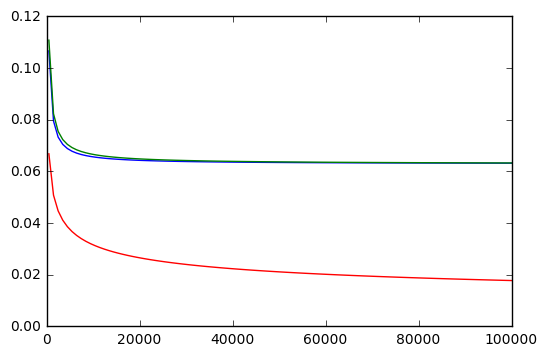

In [8]:
def frictCoeffBlas(reynolds):
    '''
    Return the friction coefficient. Blasius equation
    '''      
    if not hasattr(frictCoeffBlas, "counter"):
        frictCoeffBlas.counter = 0  # it doesn't exist yet, so initialize it
        print("frictCoeffBlas called.")
    frictCoeffBlas.counter += 1
    #
    fC =0.316/np.power(reynolds,0.25)
    return fC
#
def frictCoeffHaal(reynolds,roughCoeff):
    '''
    Return the friction coefficient.
    '''
    if not hasattr(frictCoeffHaal, "counter"):
        frictCoeffHaal.counter = 0  # it doesn't exist yet, so initialize it
        print("frictCoeffHaal called.")
    frictCoeffHaal.counter += 1
    #
    rfC = -1.8*np.log10(6.9/reynolds + np.power(roughCoeff/3.71,1.11))
    fC = 1/rfC**2
    return fC
#
def frictCoeffSJ(reynolds,roughCoeff):
    '''
    Return the friction coefficient.
    '''
    if not hasattr(frictCoeffSJ, "counter"):
        frictCoeffSJ.counter = 0  # it doesn't exist yet, so initialize it
        print("frictCoeffSJ called.")
    frictCoeffSJ.counter += 1
    #
    fC = 0.25*np.power(np.log10(5.74/np.power(reynolds,0.9)+roughCoeff/3.71),-2)
    return fC
#
reynoldsPlot = np.linspace(500,100000,101)
roughCoeff = 0.00015/diamFP
print("Roughness coefficient is {:.2f}.".format(roughCoeff))
plt.plot(reynoldsPlot,frictCoeffBlas(reynoldsPlot),'r')
plt.plot(reynoldsPlot,frictCoeffHaal(reynoldsPlot,roughCoeff),'b')
plt.plot(reynoldsPlot,frictCoeffSJ(reynoldsPlot,roughCoeff),'g')

All these expressions give similar results for smooth pipes and the two which incorporate roughness agree well for rough pipes.

Now have a look at the expression for pipe diameter with turbulent flow. This requires insertion of one of the formulae for $f_D$ into $\Delta P = \frac{8 C_f L \rho Q^2}{\pi^2 D^5}$. Try this using the Blasius equation first as the pipe should be smooth and the other two equations will give in very messy expressions. The result is, $\Delta P = 0.241 \frac{\mu^\frac{1}{4} \rho^\frac{3}{4} L Q^\frac{7}{4}}{D^\frac{19}{4}}$ which can be rearranged to give $D = 0.741\frac{\mu^\frac{1}{19} \rho^\frac{3}{19} L^\frac{4}{19} Q^\frac{7}{19}}{\Delta P^\frac{4}{19}}$.

diamPipeBlas called.


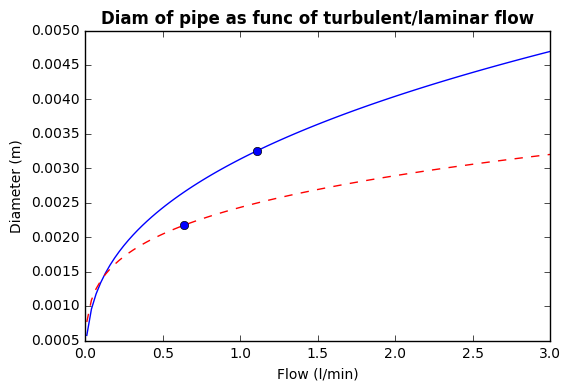

In [9]:
def diamPipeBlas(deltaP,flow,leng,temp):
    '''
    Return the diameter of a pipe that provides a certain turbulent flow rate (in litre per min) for a given
    temperature and length. Assume roughness typical for aluminium.
    '''
    if not hasattr(diamPipeBlas, "counter"):
        diamPipeBlas.counter = 0  # it doesn't exist yet, so initialize it
        print("diamPipeBlas called.")
    diamPipeBlas.counter += 1
    #
    D = 0.741*np.power(fDynVisc(temp),1/19)*np.power(rhoWater,3/19)*np.power(leng,4/19)* \
    np.power(lPerMinToMperSec(flow),7/19)/np.power(deltaP,4/19)
    return D
plt.plot(flowPlot,diamPipeBlas(pressDiffFP,flowPlot,lenFP,tempWater))
plt.plot(flowPlot,diamPipeL(pressDiffFP,flowPlot,lenFP,tempWater),"r--")
plt.plot(velToFlow(diamFP,velFromReynold(diamFP,2300,tempWater)),\
         diamPipeL(pressDiffFP,velToFlow(diamFP,velFromReynold(diamFP,2300,tempWater)),\
                   lenFP,tempWater),"bo")
plt.plot(velToFlow(diamFP,velFromReynold(diamFP,4000,tempWater)),\
         diamPipeBlas(pressDiffFP,velToFlow(diamFP,velFromReynold(diamFP,4000,tempWater)),\
                   lenFP,tempWater),"bo")
ax = plt.gca()
ax.set_title("Diam of pipe as func of turbulent/laminar flow", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Diameter (m)")

Expect laminar flow for ${\rm Re} < 2300$ and turbulent flow for ${\rm Re} > 4000$. Interpolate linearly between the two situations in the transition region. This doesn't give a smooth match!

diamPipe called.


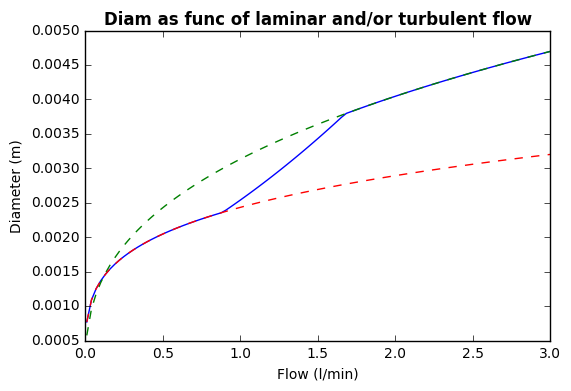

In [10]:
def diamPipe(deltaP,flow,leng,temp):
    '''
    Return the diameter of a pipe that provides a certain flow rate (in litres per min) for 
    a given temperature and length, interpolating between the
    laminar (Re < 2300) and turbulent (Re > 4000) regions
    '''
    if not hasattr(diamPipe, "counter"):
        diamPipe.counter = 0  # it doesn't exist yet, so initialize it
        print("diamPipe called.")
    diamPipe.counter += 1
    #
    # calculate laminar and turbulent diameters
    dL = diamPipeL(deltaP,flow,leng,temp)
    dT = diamPipeBlas(deltaP,flow,leng,temp)
    # calculate Re for these diameters
    ReL = Reynold(dL,temp,flowToVel(dL,flow))
    ReT = Reynold(dT,temp,flowToVel(dT,flow))
    # need flow at which ReL = 2300 and at which ReT = 4000 for interpolation
    flowReL = mPerSecToLperMin(velFromReynold(dL,2300,temp))
    flowReT = mPerSecToLperMin(velFromReynold(dT,4000,temp))
    # hence get interpolated Re in transition region
    Re = (2300*(flowReT - flow) + 4000*(flow - flowReL))/(flowReL - flowReT) 
    boolL = Re < 2300 
    boolT = Re > 4000
    boolM = np.logical_not(np.logical_or(boolL,boolT))
    fL = boolM*(4000 - Re)/(4000 - 2300)
    fT = boolM*(Re - 2300)/(4000 - 2300)
    D =  boolL*dL + boolT*dT + fL*dL + fT*dT
    return D
plt.plot(flowPlot,diamPipe(pressDiffFP,flowPlot,lenFP,tempWater),"b")
plt.plot(flowPlot,diamPipeBlas(pressDiffFP,flowPlot,lenFP,tempWater),"g--")
plt.plot(flowPlot,diamPipeL(pressDiffFP,flowPlot,lenFP,tempWater),"r--")
ax = plt.gca()
ax.set_title("Diam as func of laminar and/or turbulent flow", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Diameter (m)")

If need to remove a certain amount of power $W$, and have an allowed temperature change $\Delta T$, then the required flow rate is $Q = \frac{W}{\Delta T \rho c}$, where $c$ is the specific heat capacity. This assumes that the temperature of the CHEC body (electronics) is the same as that of the water. This will not be anywhere near true because the internal cooling is via circulating air. Will need to get the real required flow rate from experience!

Temperature difference allowed is 10.0 C.
flowReq called.


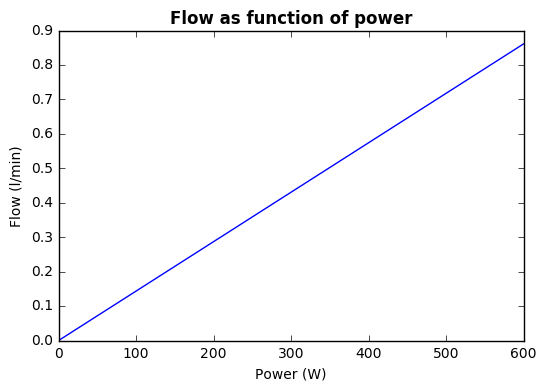

In [11]:
def flowReq(deltaTemp,power):
    '''
    Calculate the flow rate (in litres per min) required to cool a certain power with a
    given temperature increase
    '''
    if not hasattr(flowReq, "counter"):
        flowReq.counter = 0  # it doesn't exist yet, so initialize it
        print("flowReq called.")
    flowReq.counter += 1
    #
    flowMperSec = power/(deltaTemp*rhoWater*specHeatWater)
    flow = mPerSecToLperMin(flowMperSec)
    return flow
powerArr = np.linspace(0.0,600,51)
print("Temperature difference allowed is {:.1f} C.".format(tempDiffFP))
plt.plot(powerArr,flowReq(tempDiffFP,powerArr))
ax = plt.gca()
ax.set_title("Flow as function of power", size = 12, weight = "bold")
ax.set_xlabel("Power (W)")
ax.set_ylabel("Flow (l/min)")

Minimum possible flow rate to limit temperature rise in camera to 10 C is around 0.8 litres/min (assumes 100% efficiency of transfer of produced heat to water - far from true). Actual flow rate proposed is around 8 litres/min. There are five ribs in parallel in the focal plane, so each of these will have a flow rate of about 1.6 litres/min. What pressure drop will be needed to produce this flow rate? The relevant formula in the laminar flow region is $\Delta P = \frac{{128\mu LQ}}{{\pi {D^4}}}$. In the turbulent region, it is $\Delta P = 0.241\frac{{L{\rho ^{\frac{3}{4}}}{\mu ^{\frac{1}{4}}}{Q^{\frac{7}{4}}}}}{{{D^{\frac{{19}}{4}}}}}$.

pressAsFuncOfFlowL called.
pressAsFuncOfFlowBlas called.
Pressure to get flow rate of 1.6 l/min is 0.072 bar.


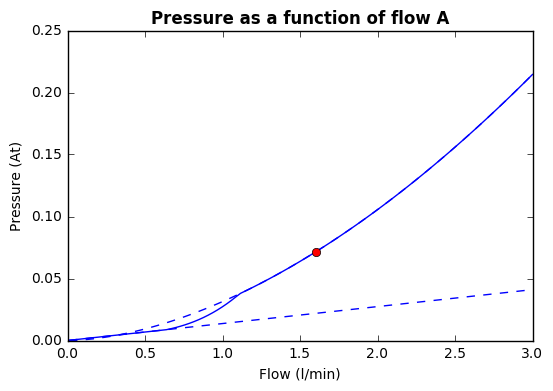

In [12]:
def pressAsFuncOfFlowL(diam,flow,leng,temp):
    '''
    Return the pressure drop required to achieve a given flow rate (in litres/min) for a
    certain diameter and length of pipe at a given temperature for laminar flow.
    '''
    if not hasattr(pressAsFuncOfFlowL, "counter"):
        pressAsFuncOfFlowL.counter = 0  # it doesn't exist yet, so initialize it
        print("pressAsFuncOfFlowL called.")
    pressAsFuncOfFlowL.counter += 1
    #
    pL = 128*fDynVisc(temp)*leng*lPerMinToMperSec(flow)/(np.pi*diam**4)
    return pL
#
def pressAsFuncOfFlowBlas(diam,flow,leng,temp):
    '''
    Return the pressure drop required to achieve a given flow rate (in litres/min) for a
    certain diameter and length of pipe at a given temperature for turbulent flow.
    '''
    if not hasattr(pressAsFuncOfFlowBlas, "counter"):
        pressAsFuncOfFlowBlas.counter = 0  # it doesn't exist yet, so initialize it
        print("pressAsFuncOfFlowBlas called.")
    pressAsFuncOfFlowBlas.counter += 1
    #
    pT = 0.241*leng*np.power(rhoWater,3/4)*np.power(fDynVisc(temp),1/4)* \
        np.power(lPerMinToMperSec(flow),7/4)/np.power(diam,19/4)
    return pT
#
def pressAsFuncOfFlow(diam,flow,leng,temp):
    '''
    Return the pressure drop required to achieve a given flow rate (in litres/min) for a
    certain diameter and length of pipe at a given temperature, interpolating linearly
    (in Re) between the laminar (Re < 2300) and turbulent (Re > 4000) regions
    '''
    if not hasattr(velToFlow, "counter"):
        velToFlow.counter = 0  # it doesn't exist yet, so initialize it
        print("velToFlow called.")
    velToFlow.counter += 1
    #
    Re = Reynold(diam,temp,flowToVel(diam,flow))
    aL = Re < 2300 
    aT = Re > 4000
    aM = np.logical_not(np.logical_or(aL,aT))
    pL = pressAsFuncOfFlowL(diam,flow,leng,temp)
    pT = pressAsFuncOfFlowBlas(diam,flow,leng,temp)
    fL = aM*(4000 - Re)/(4000 - 2300)
    fT = aM*(Re - 2300)/(4000 - 2300)
    P =  aL*pL + aT*pT + fL*pL + fT*pT
    return P
#
print("Pressure to get flow rate of 1.6 l/min is {:.3f} bar.".\
      format(pressAsFuncOfFlow(diamFP,1.6,lenFP,tempWater)/(0.987*10**5)," bar."))
plt.plot(flowPlot,pressAsFuncOfFlowL(diamFP,flowPlot,lenFP,tempWater)/10**5,"b--")
plt.plot(flowPlot,pressAsFuncOfFlowBlas(diamFP,flowPlot,lenFP,tempWater)/10**5,"b--")
plt.plot(flowPlot,pressAsFuncOfFlow(diamFP,flowPlot,lenFP,tempWater)/10**5)
plt.plot(1.6,pressAsFuncOfFlow(diamFP,1.6,lenFP,tempWater)/10**5,"ro")
ax = plt.gca()
ax.set_title("Pressure as a function of flow A", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Pressure (At)")

The online calculator used by Duncan expects roughly $\Delta P = 0.07$ bar under CHEC conditions (i.e. flow rate of about 1.6 litres/min, channel length 0.35 m, pipe diameter 4 mm and water temperature 6 C). Reasonable agreement with above plot, using conversion that 1 bar = 0.987 At.

Now look at modelling entire system, i.e. pipe from chiller, focal plane with 5 ribs, pipe to camera body, cooling in camera body and pipe back to chiller. Want to know first what flow rate is needed in each element to ensure adequate cooling.

In [13]:
def flowReqCHEC(deltaTFP,powerFP,deltaTB,powerB):
    '''
    Return flow (l/min) required to ensure all elements of CHEC are adequately cooled
    '''
    if not hasattr(flowReqCHEC, "counter"):
        flowReqCHEC.counter = 0  # it doesn't exist yet, so initialize it
        print("flowReqCHEC called.")
    flowReqCHEC.counter += 1
    #
    # Efficiency of cooling
    #
    eFP = 1.0
    eB = 0.1
    fFP = flowReq(deltaTFP,powerFP)/eFP
    fB = flowReq(deltaTB,powerB)/eB
    flow = np.maximum(fFP,fB)
    print("Flow for FP {:.2f} l/min, flow for CHEC body {:.2f} l/min".format(fFP,fB))
    return flow
flowCHEC = flowReqCHEC(deltaTFP,powerFP,deltaTB,powerB)
print("Flow required for cooling is {:.2f} l/min.".format(flowCHEC))

flowReqCHEC called.
Flow for FP 0.46 l/min, flow for CHEC body 8.61 l/min
Flow required for cooling is 8.61 l/min.


Now want to know dynamic pressure drop across the system given the necessary flow rate (or flow rate given the pressure drop).

Define function that gives pressure across system for a given flow rate.

pressCHEC called.
DP for inlet 0.25 At.
DP for FP 0.08 At.
DP for FP to body 0.0041 At.
DP for body 0.5907 At.
DP for outlet 0.23 At.
Pressure needed for flow of 8.61 l/min is 1.16 At.


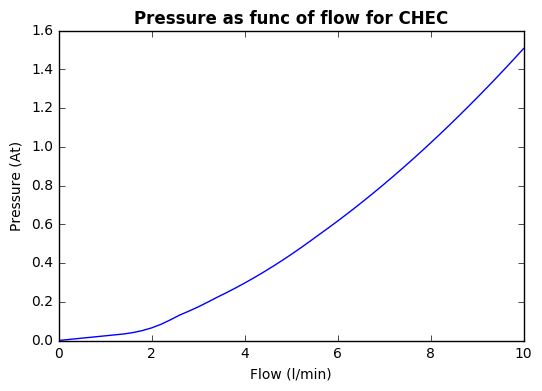

In [14]:
def pressCHEC(flow):
    '''
    Returns pressure (Pa) across entire CHEC cooling system for a given flow of coolant (l/min) 
    '''
    if not hasattr(pressCHEC, "counter"):
        pressCHEC.counter = 0  # it doesn't exist yet, so initialize it
        print("pressCHEC called.")
    pressCHEC.counter += 1
    #
# First determine approximate Reynolds number in each element to know which equations to use
#
    temp = tempWater
    pIn = pressAsFuncOfFlow(diamIn,flow,lenIn,temp)
    temp = temp
    pFP = pressAsFuncOfFlow(diamFP,flow/numFP,lenFP,temp)
    temp = temp + deltaTFP
    pFPtoB = pressAsFuncOfFlow(diamFPtoB,flow,lenFPtoB,temp)
    temp = temp
    pB = pressAsFuncOfFlow(diamB,flow,lenIn,temp)
    temp = temp + deltaTB
    pOut = pressAsFuncOfFlow(diamOut,flow,lenOut,temp)
    dP = pIn + pFP + pFPtoB + pB + pOut
    return pIn,pFP,pFPtoB,pB,pOut,dP
#
print("DP for inlet {:.2f} At.".format(pressCHEC(flowCHEC)[0]/10**5))
print("DP for FP {:.2f} At.".format(pressCHEC(flowCHEC)[1]/10**5))
print("DP for FP to body {:.4f} At.".format(pressCHEC(flowCHEC)[2]/10**5))
print("DP for body {:.4f} At.".format(pressCHEC(flowCHEC)[3]/10**5))
print("DP for outlet {:.2f} At.".format(pressCHEC(flowCHEC)[4]/10**5))
print("Pressure needed for flow of {:.2f} l/min is {:.2f} At.".\
      format(flowCHEC,pressCHEC(flowCHEC)[5]/10**5))
flowPlotCHEC = np.linspace(0.0,10.0,51)
plt.plot(flowPlotCHEC,pressCHEC(flowPlotCHEC)[5]/10**5)
ax = plt.gca()
ax.set_title("Pressure as func of flow for CHEC", size = 12, weight = "bold")
ax.set_xlabel("Flow (l/min)")
ax.set_ylabel("Pressure (At)")